In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/hw2

/content/drive/MyDrive/hw2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords

In [4]:
# Read the input text file into a DataFrame
df = pd.read_csv('data.txt')
df = df.sample(frac=1)

In [5]:
df = df.drop(columns=['Unnamed: 0'])

no_neutral = False

df = df.rename(columns={'text':'review', 'stars':'sentiment'})

if no_neutral:
    df = df[df['sentiment']!=3]
    df['sentiment'] = df['sentiment'].apply(lambda x: int(x>3))
else:
    df['sentiment'] = df['sentiment'].apply(lambda x: np.sign(x-3)+1)

In [6]:
from tensorflow.keras.utils import to_categorical

label = df.sentiment
label.unique()
num_classes = len(set(label))
one_hot_labels = to_categorical(label, num_classes=num_classes)

In [7]:
from gensim.parsing.porter import PorterStemmer
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
porter_stemmer = PorterStemmer()
review = df.review.values
review = [simple_preprocess(line, deacc=True) for line in review] 
review = [[porter_stemmer.stem(word) for word in tokens] for tokens in review]
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(review)
sequences = tokenizer.texts_to_sequences(review)

In [8]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

26781

In [9]:
maxlen = 100
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

In [10]:
from sklearn.model_selection import train_test_split
#split data into training and testing
padded_sequences, test_padded_sequences = train_test_split(padded_sequences, test_size=0.2, shuffle=False)
one_hot_labels, test_one_hot_labels = train_test_split(one_hot_labels, test_size=0.2, shuffle=False)

In [11]:
print(tokenizer.word_index)

{'the': 1, 'and': 2, 'to': 3, 'wa': 4, 'it': 5, 'of': 6, 'for': 7, 'is': 8, 'in': 9, 'on': 10, 'that': 11, 'we': 12, 'but': 13, 'my': 14, 'thei': 15, 'with': 16, 'thi': 17, 'not': 18, 'you': 19, 'have': 20, 'were': 21, 'had': 22, 'food': 23, 'at': 24, 'be': 25, 'so': 26, 'good': 27, 'place': 28, 'ar': 29, 'there': 30, 'as': 31, 'order': 32, 'time': 33, 'like': 34, 'veri': 35, 'if': 36, 'our': 37, 'out': 38, 'go': 39, 'me': 40, 'get': 41, 'just': 42, 'all': 43, 'servic': 44, 'great': 45, 'here': 46, 'would': 47, 'us': 48, 'when': 49, 'or': 50, 'up': 51, 'their': 52, 'back': 53, 'from': 54, 'an': 55, 'about': 56, 'no': 57, 'which': 58, 'can': 59, 'realli': 60, 'she': 61, 'what': 62, 'will': 63, 'been': 64, 'some': 65, 'more': 66, 'he': 67, 'onli': 68, 'other': 69, 'wait': 70, 'got': 71, 'becaus': 72, 'even': 73, 'also': 74, 'restaur': 75, 'them': 76, 'do': 77, 'don': 78, 'nice': 79, 'come': 80, 'by': 81, 'your': 82, 'look': 83, 'want': 84, 've': 85, 'after': 86, 'price': 87, 'too': 88, '

In [12]:
print(review[0])
print(sequences[0])

['just', 'got', 'my', 'deliveri', 'of', 'honei', 'bbq', 'wing', 'sampler', 'and', 'whole', 'chees', 'steak', 'quick', 'servic', 'delici', 'choic', 'for', 'lazi', 'dai', 'wing', 'were', 'realli', 'meati', 'and', 'sauci', 'bonu', 'sampler', 'came', 'with', 'littl', 'bit', 'of', 'everyth', 'bonu', 'is', 'the', 'varieti', 'of', 'sauc', 'to', 'dip', 'with', 'thank', 'you', 'chees', 'steak', 'wa', 'jot', 'my', 'meal', 'but', 'from', 'the', 'look', 'of', 'it', 'the', 'bread', 'wa', 'freshli', 'made', 'as', 'describ', 'by', 'other', 'yelper', 'thi', 'place', 'is', 'neighborhood', 'gem', 'glad', 'found', 'it']
[42, 71, 14, 683, 6, 1094, 523, 428, 1930, 2, 403, 158, 330, 424, 44, 167, 394, 7, 1821, 117, 428, 21, 60, 3296, 2, 4098, 1777, 1930, 93, 16, 104, 187, 6, 219, 1777, 8, 1, 596, 6, 149, 3, 770, 16, 480, 19, 158, 330, 4, 14, 160, 13, 54, 1, 83, 6, 5, 1, 255, 4, 1822, 143, 31, 1187, 81, 69, 1916, 17, 28, 8, 746, 1222, 822, 305, 5]


In [13]:
print(padded_sequences[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   42   71
   14  683    6 1094  523  428 1930    2  403  158  330  424   44  167
  394    7 1821  117  428   21   60 3296    2 4098 1777 1930   93   16
  104  187    6  219 1777    8    1  596    6  149    3  770   16  480
   19  158  330    4   14  160   13   54    1   83    6    5    1  255
    4 1822  143   31 1187   81   69 1916   17   28    8  746 1222  822
  305    5]


In [14]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

num_classes = len(label.unique())
window_sizes = [2, 3, 4, 5]
num_filters = 10
architecture = "CNN"
activation = "tanh"

if architecture == "LSTM":
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=30, input_length=maxlen))
    model.add(SpatialDropout1D(0.25))
    model.add(LSTM(64, activation=activation, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
else:
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=30, input_length=maxlen))
    model.add(SpatialDropout1D(0.25))
    model.add(Conv1D(num_filters, kernel_size=window_sizes[0], activation=activation))
    model.add(MaxPooling1D())
    for window_size in window_sizes[1:]:
        model.add(Conv1D(num_filters, kernel_size=window_size, activation=activation))
        model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 30)           803430    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 30)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 99, 10)            610       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 10)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 10)            310       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 10)           0

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(padded_sequences,one_hot_labels,validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
600/600 [==============================] - 47s 70ms/step - loss: 0.9810 - accuracy: 0.4820 - val_loss: 0.8361 - val_accuracy: 0.5983
Epoch 2/20
600/600 [==============================] - 10s 16ms/step - loss: 0.6944 - accuracy: 0.6953 - val_loss: 0.7002 - val_accuracy: 0.6800
Epoch 3/20
600/600 [==============================] - 6s 10ms/step - loss: 0.5911 - accuracy: 0.7518 - val_loss: 0.6913 - val_accuracy: 0.6919
Epoch 4/20
600/600 [==============================] - 7s 11ms/step - loss: 0.5294 - accuracy: 0.7844 - val_loss: 0.6931 - val_accuracy: 0.7006
Epoch 5/20
600/600 [==============================] - 4s 7ms/step - loss: 0.4856 - accuracy: 0.8037 - val_loss: 0.7549 - val_accuracy: 0.6815
Epoch 6/20
600/600 [==============================] - 5s 8ms/step - loss: 0.4427 - accuracy: 0.8230 - val_loss: 0.7643 - val_accuracy: 0.6881


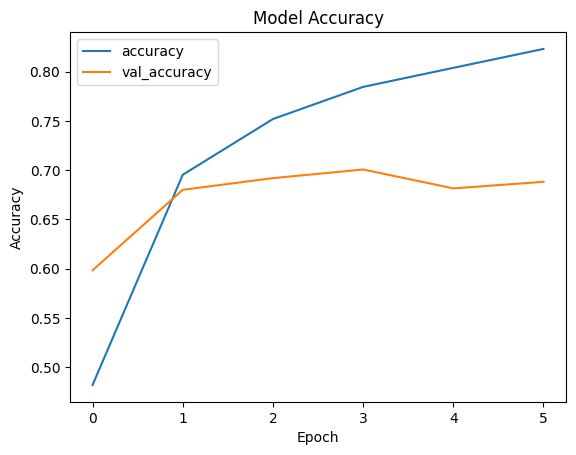

In [16]:
# Plot training and validation accuracy scores
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

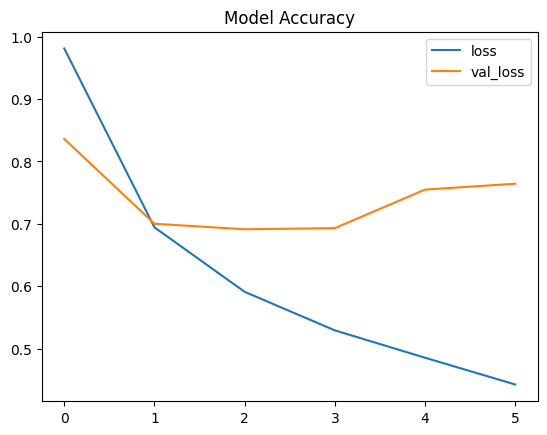

In [17]:
# Plot training and validation accuracy scores
plt.plot(history.history['loss'], label ='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [18]:
loss, accuracy = model.evaluate(test_padded_sequences, test_one_hot_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

188/188 [==============================] - 1s 4ms/step - loss: 0.7905 - accuracy: 0.6887
Accuracy: 68.87%


In [19]:
from sklearn.metrics import classification_report

# Make predictions using the trained model
y_pred = model.predict(test_padded_sequences)

# Convert the predictions from probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(np.argmax(test_one_hot_labels, axis=1), y_pred))

188/188 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1957
           1       0.58      0.60      0.59      2012
           2       0.75      0.75      0.75      2031

    accuracy                           0.69      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.69      0.69      0.69      6000

